# Hyperparameter Tuning

This notebook determines the best set of hyperparameters to train the portfolio optimization model.

Since the training jobs are becoming longer, we will use [spot](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html) instances.

#### Import necessary modules

In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import boto3
from IPython.display import Image
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.session import Session
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import shutil


#### Set local parameters

In [42]:
image_type = 'cpu'
instance_type = 'ml.m5.large'
max_parallel_jobs = 6

#image_type = 'gpu'
#instance_type = 'ml.g4dn.xlarge'
#max_parallel_jobs = 2

n_instances = 1
max_jobs = 48

train_use_spot_instances = True
train_max_run=14400
train_max_wait = 14400 if train_use_spot_instances else None

#### Compile environment

In [43]:
role = get_execution_role()
account = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name
image_name = '{}.dkr.ecr.{}.amazonaws.com/portfolio-optimization-{}:latest'.format(account, region, image_type)
print(image_name)

031118886020.dkr.ecr.us-east-1.amazonaws.com/portfolio-optimization-cpu:latest


#### Set the objective
Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits the objective metric directly, which we will 'Maximize'.  The actual objective metric $O$ is defined below.

$
\qquad O = 100,000 \cdot max(0, T - A) + t - 1,000\cdot max(A - T) \\
\qquad \qquad \text{where:} \\
\qquad \qquad \qquad A = \text{Annualized Alpha} \\
\qquad \qquad \qquad T = \text{Target Alpha} \\
\qquad \qquad \qquad t = \text{The total training time in minutes} \\
$

In [44]:
objective_metric_name = 'Trading Performance'
objective_type = 'Minimize'
metric_definitions = [{'Name': objective_metric_name,
                       'Regex': '(\S+) training objective.'}]

#### Define the hyperparameters to optimize
The following hyperparameters are read from the command line in [train.py](container/src/train.py).

| Name            | Type  | Default  | Description                        |
|-----------------|-------|----------|------------------------------------|
| max_epochs      | int   |    2000  | max epochs per new trading day     |
| days_per_epoch  | int   |      40  | days in each epoch                 |
| start_day       | int   |     504  | day to begin training              |
| window_length   | int   |      10  | CNN window length                  |
| memory_strength | float |     2.0  | memory exponential gain            |
| target          | float |    0.05  | target annual alpha                |
| fc1             | int   |       9  | size of 1st hidden layer           |
| fc2             | int   |       0  | size of 2bd hidden layer           |
| lr_actor        | float | 0.000371 | initial learning rate for actor    |
| lr_critic       | float |   0.0011 | initial learning rate for critic   |
| batch_size      | int   |      256 | mini batch size                    |
| buffer_size     | int   |   100000 | replay buffer size                 |
| gamma           | float |     0.91 | discount factor                    |
| tau             | float |   0.0072 | soft update of target parameters   |
| sigma           | float |      0.0 | OU Noise standard deviation        |
| theta           | float |      0.0 | OU Noise theta gain                |

Any of these could be tuned but we will down select to limit the search.    

The hyperparameter tunner allow the hyperparameters to be defined as one of the following types. 
- `CategoricalParameter(list)` Categorical parameters need to take one value from a discrete set. 
- `ContinuousParameter(min, max)` Continuous parameters can take any real number value between the minimum and maximum value.
- `IntegerParameter(min, max)` Integer parameters can take any integer value between the minimum and maximum value.

_Note, if possible, it's almost always best to specify a value as the least restrictive type. For example, tuning learning rate as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with values 0.01, 0.1, 0.15, or 0.2. Sometimes a parameter is categorical to limit the search space._

_Also parameters maybe group a sequence of optimization may be executed._

In [45]:
hyperparameter_ranges = {
    'fc1': IntegerParameter(6, 36),
    'lr_actor': ContinuousParameter(0.0001, 0.001),
    'lr_critic': ContinuousParameter(0.0005, 0.005)}

hyperparameters = {'start_day': 2670,
                   'days_per_epoch': 40,
                   'fc2': 0}

#### Create the base estimator

In [46]:
estimator = Estimator(role=role,
                  train_instance_count=n_instances,
                  train_instance_type=instance_type,
                  image_name=image_name,
                  train_use_spot_instances=train_use_spot_instances,
                  train_max_run=train_max_run,
                  train_max_wait=train_max_wait,
                  hyperparameters=hyperparameters)

#### Create the hyperparameter tuner object

In [47]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=max_jobs,
                            max_parallel_jobs=max_parallel_jobs,
                            objective_type=objective_type)

#### Perform the hyperparameter tuning
After the hyperprameter tuning job is created, you should be able to describe the tuning job to see its progress in the next step, and you can go to SageMaker console -> `Training` -> `Hyperparameter tuning jobs` to see the progresss.

In [48]:
tuner.fit()
tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [49]:
best_parameters = tuner.best_estimator().hyperparameters()


2020-07-22 23:04:19 Starting - Preparing the instances for training
2020-07-22 23:04:19 Downloading - Downloading input data
2020-07-22 23:04:19 Training - Training image download completed. Training in progress.
2020-07-22 23:04:19 Uploading - Uploading generated training model
2020-07-22 23:04:19 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-22 20:37:26,466 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-22 20:37:26,467 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value Trading Performance to Json.
Returning the value itself
2020-07-22 20:37:26,469 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-22 20:37:26,480 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-22 20:37:32,727 sagemaker_pytorch_container.trainin

In [50]:
best_name = tuner.best_training_job()
print('\nBest model = {}.'.format(best_name))
for name in hyperparameter_ranges.keys():
    print('\t{} = {}'.format(name, best_parameters[name]))


Best model = portfolio-optimizati-200722-2034-005-b410c5f1.
	fc1 = 13
	lr_actor = 0.00038964106667734705
	lr_critic = 0.0035606177627894903


#### Compare optimal hyperparameters to manually optimized values.
| Name        | Type  | Default | Description                        |
|-------------|-------|---------|------------------------------------|
| fc1         | int   |       9 | size of 1st hidden layer           |
| lr_actor    | float |  0.0001 | initial learning rate for actor    |
| lr_critic   | float |   0.001 | initial learning rate for critic   |


# Review the Results

#### Copy and unpack the optimum result archive

In [51]:
sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file('{}/output/output.tar.gz'.format(best_name), 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

#### View the optimial results

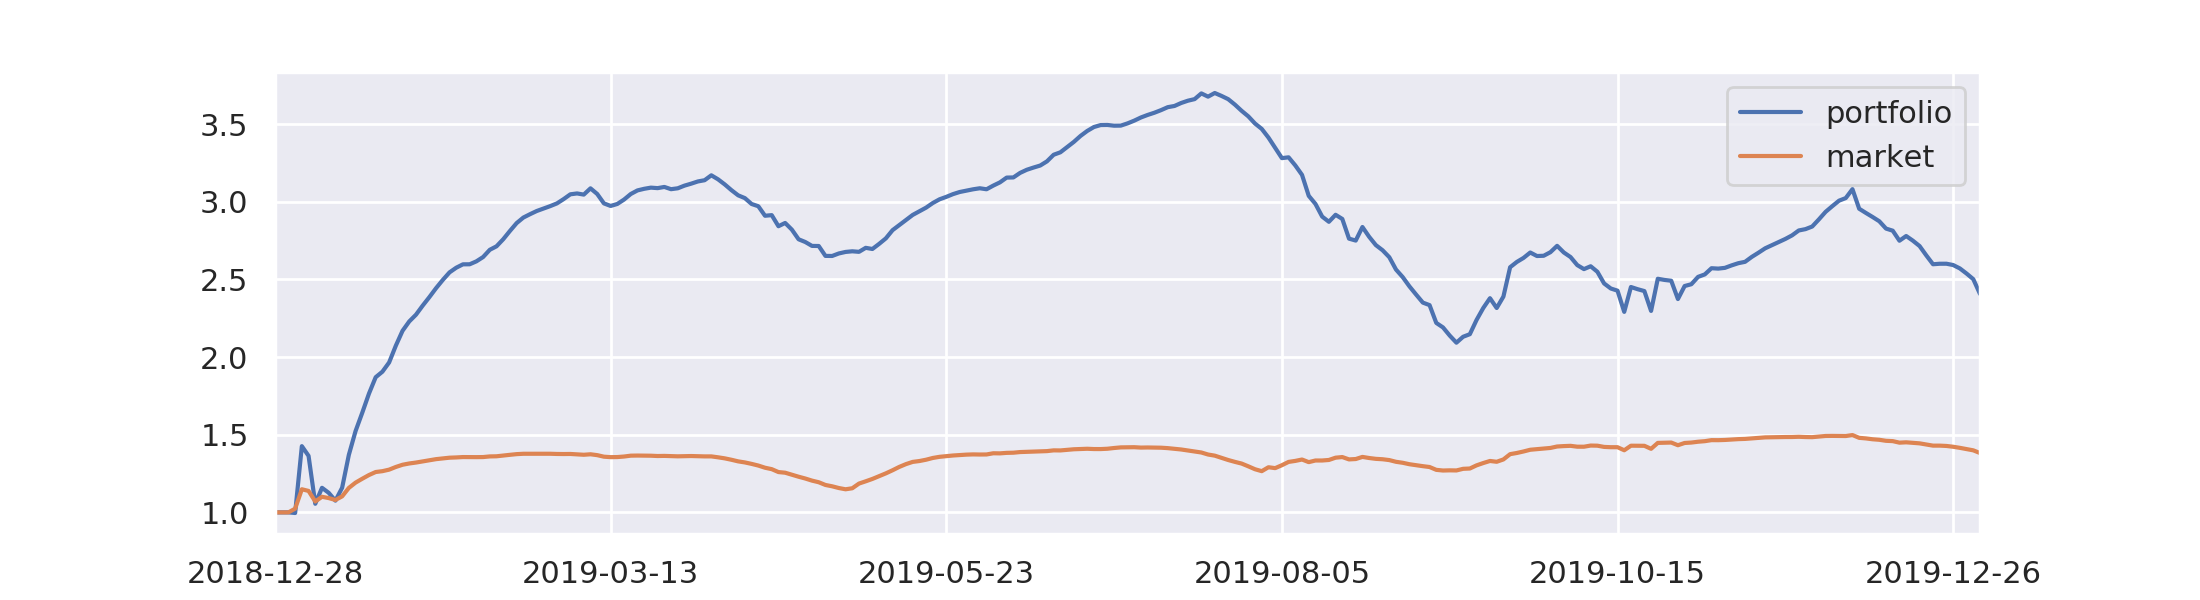

In [52]:
Image(filename='history.png') 

# Reference
- [SageMaker Spot Docs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html)
- [SageMaker Spot Example](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/managed_spot_training_object_detection)
- [SageMaker Tuning Example](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning/pytorch_mnist)
- [How Hyperparameter Tuning Works](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html)
- [Tuner API](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)
- [Estimater API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase)